In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from PIL import Image
import pickle

## Sensitivity analysis

First, we performed sensitivity analysis on jupedsim (see jupedsim/sa and jupedsim/sa_1d notebooks), and discovered that three of the five tested parameters appeared to have a noticeable effect on the model. These are:
- **force_ped_a** The strength of the interaction when one pedestrian tries to avoid coming into contact with another pedestrian.
- **force_ped_D** The maximum distance another pedestrian can be to provoke a reaction (of avoiding them).
- **v_mu** The desired mean velocity of pedestrians.

Through further tests (not provided in the notebook) we also found that force_ped_a cannot reasonabily be greater than 6.6 as pedestrians are then unable to easily move around the environment because the strength of their effort to avoid others is too high.

## Generating pedestrians

The file activiation.dat lists information on pedestrian arrivals and exits within a window of approximately three minutes of the data. We want to know where people travel, so we're interested in the gate_in and gate_out.


In [2]:
activation = pd.read_csv('data/activation.dat', delimiter=' ', comment='#', names=['pedestrianID', 'time_activation', 'gate_in', 'gate_out', 'speed'])
activation.head()

,pedestrianID,time_activation,gate_in,gate_out,speed
0,0,2273.0,8,5,1.417886
1,1,2401.0,9,3,1.130044
2,2,2411.0,9,3,1.120553
3,3,2564.0,9,1,0.554143
4,4,2591.0,9,1,0.600241


Next, we find out the total people travelling from each gate to each other gate.

This table shows, for example, that a total of nine people travelled from gate 0 to gate 1, and four people travelled from gate 1 to gate 0.

In [3]:
TOTAL_GATES = 11
FPS = 25

# total people journeying from each gate to each other gate
path_totals = np.zeros((TOTAL_GATES, TOTAL_GATES), dtype=int)

# The the first and last frame no so we know the period of time associated with the data
min_time = np.inf
max_time = -np.inf

for index, row in activation.iterrows():
    time_in = float(row.time_activation)
    min_time = min(min_time, time_in)
    max_time = max(max_time, time_in)
    gate_in = int(row.gate_in)
    gate_out = int(row.gate_out)
    path_totals[gate_in][gate_out] += 1

cols = list(range(TOTAL_GATES))
df = pd.DataFrame(path_totals, columns=cols, index=cols)
df

,0,1,2,3,4,5,6,7,8,9,10
0,0,9,2,0,1,10,0,0,4,0,1
1,4,0,0,0,4,21,0,8,9,12,5
2,1,0,0,1,3,7,0,2,1,9,6
3,1,0,0,0,0,0,0,0,0,1,0
4,0,0,4,0,0,0,0,1,2,0,0
5,1,0,2,2,0,0,0,0,0,1,0
6,1,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0,0
8,1,9,10,2,5,28,1,0,0,0,0
9,5,19,8,2,6,32,1,0,0,0,0


We next format the data so we can pass it to jupedsim. This involves removing all paths that no one took, and creating a unique *group_id* for each path.

For group 0, within 158 seconds a total of 9 people travelled from gate 0 to gate 1. This averages at one person every 18 seconds. Therefore, we will tell jupedsim to create one person at gate 0 every 18 seconds who will then travel to gate 1. (Of course, other people will also appear at gate 0 heading to gates 2, 4, 5, 8, and 10.)

*There's some extra code that further converts this table into xml format (used by Jupedsim) but it's omitted from the notebook as it doesn't provide any new information (it's just the table reformatted).*

**Possibile limitation:**
This method of introducing people into the environment may be a limitation of the model. As the environment is a train station concourse, in reality most people would arrive in bursts (as a train arrives) rather than one at a time. Jupedsim will only accept an input of n people every t seconds. An alternative to 1 person every t seconds (which we're currently doing) is to have people arrive in bursts that are more spread out over time. For example, 32 people travel from gate 9 to gate 5 within the three minutes. Instead of having one person arrive every 5 seconds, it may reflect reality better if all 32 people arrive at the same time (followed by another 32 people three minutes later), or if 16 people arrive at once (followed by another 16 people 90 seconds later).

In [4]:
total_time = (max_time - min_time) / FPS

table = []
i = 0
for entry in range(TOTAL_GATES):
    for exit in range(TOTAL_GATES):
        if path_totals[entry][exit] > 0: # Some routes are never used
            # Calculate the average time interval between people entering through a given gate.
            # Using the actual times would be better to form a distribution,
            # but jupedsim will only take a single interval.
            time_interval = int(round(total_time / path_totals[entry][exit]))
            table.append([i, entry, exit, path_totals[entry][exit], time_interval])
            i += 1
print('Total time: %f' % total_time)
print(tabulate(table, headers=('group_id', 'entrance', 'exit', 'total people', 'avg time between entry')))

Total time: 158.280000
  group_id    entrance    exit    total people    avg time between entry
----------  ----------  ------  --------------  ------------------------
         0           0       1               9                        18
         1           0       2               2                        79
         2           0       4               1                       158
         3           0       5              10                        16
         4           0       8               4                        40
         5           0      10               1                       158
         6           1       0               4                        40
         7           1       4               4                        40
         8           1       5              21                         8
         9           1       7               8                        20
        10           1       8               9                        18
        11           1      

## Creating a model to match the data

### Population density in the data

We then calculate the population density in the data in three areas.
- **Zone 1** A sparcely populated area
- **Zone 2** A densely populated area
- **Zone 3** The whole environment

This image splits the environment into a grid of 2x2m cells and measures the voronoi density of pedestrians within each cell from the data. Blue indicates low density, whilst yellow-red indicates high density. The density is measured every 30 seconds, which is then averaged across 20 minutes of the data.

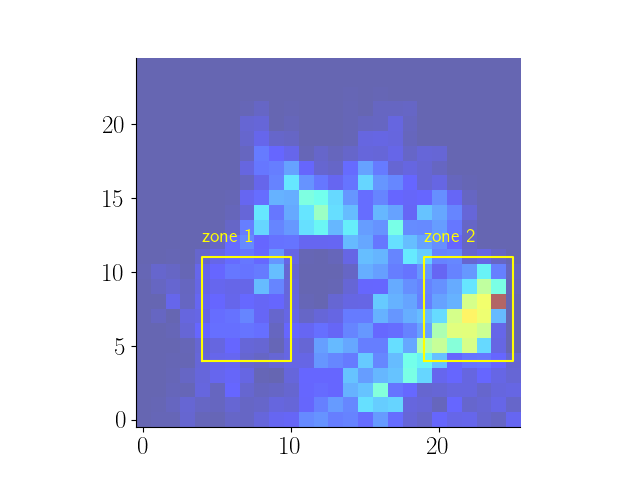

In [5]:
image = Image.open('data/figures/average_density_zones.png')
display(image)

The density of zone 1 is similar to the density of the whole environment on average (zone 3). Whereas zone 2 is approximately 2.3 times as dense.

In [6]:
# Get density of the zones
for i in (1, 2, 3):
    with open('data/average_density_zone%d.pkl' % i, 'rb') as pfile:
        d = pickle.load(pfile)
        print('Zone %d density: %f' % (i, d))


Zone 1 density: 0.062863
Zone 2 density: 0.143204
Zone 3 density: 0.053481


## History Matching

We want to know if different model parameters are needed to accurately model pedestrian movement in sparse and dense environments. We performed history matching on the model three times (once for each zone). <br> *Note that in the figure of results you can highlight part of an axis to make those results stand out above others if the plot feels too crowded.*

__force-ped-a__: For both zones 1 and 2, a wide range of values are found to be plausible for force-ped-a. This suggests the model may not actually be sensitive to this parameter. For zone 3, it is slightly narrower (approximately [3, 5]).


__force-ped-D__: The plausible values of force-ped-d are not similar in zones 1 and 2. For zone 1, values are accepted in the range [0.2, 1], in zone 2 the range is narrowed to [0.5, 0.82], and in zone 3 it is around [0.55, 1].
In the sparce region (zone 1), a pedestrian may be either close or far away for an agent to start moving to avoid them. Whereas in the dense region (zone 2), there is a much more narrow distance that people look for others that may need avoiding.


__v-mu__: The plausible average velocity (v-mu) of pedestrians also differs between zones. In zone 1 it is around [0.6, 0.65], in zone 2 it is in [0.9, 1.1], and in zone 3 it is in [1.1, 1.2]. The range of plausible values for v-mu is much narrower than for force-ped-a and force-ped-D, suggesting the model is more sensitive to this parameter. It is also interesting that there is no overlap between plausible values of v-mu across the three zones.


**Limitation of results**: The history matching process was run for 3 waves and then stopped. Further waves were not carried out for the sake of time. However, further waves may reduce the plausible space even further and highlight greater differences in the results of the three zones.

In [7]:
import os
os.chdir('jupedsim')
from jupedsim import jupedsim_hm as hm

In [ ]:
z1_results = hm.load_results('results/210927_112631')
z2_results = hm.load_results('results/210928_181919')
z3_results = hm.load_results('results/211018_143754')
hm.plot_zones_parallel((z1_results[-1], z2_results[-1], z3_results[-1]))

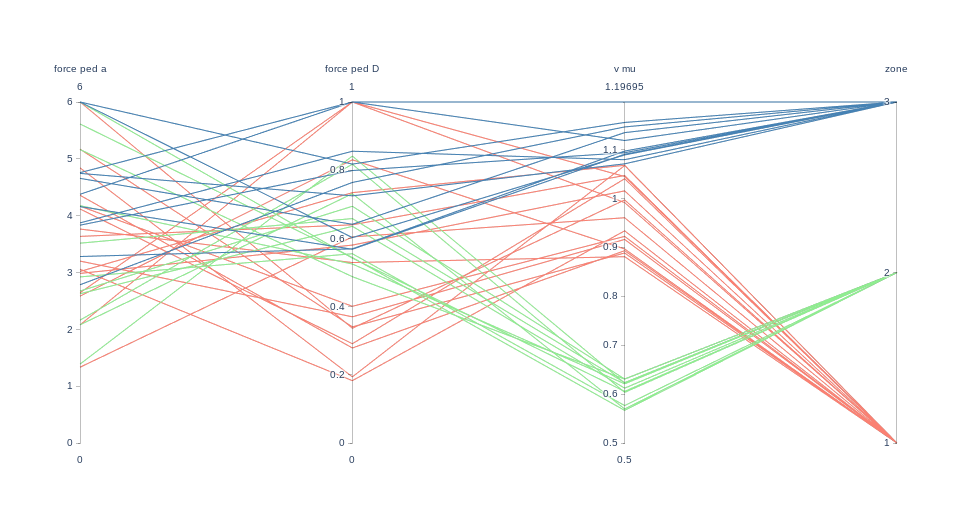

In [9]:
# Load saved image as parallel plots don't save within the notebook.
image = Image.open('../hm_data_pp.png')
display(image)

## Using a *true* model run

We next tested to see what results we get if we use a single run of the model as *true* data and perform history matching to match this. We ran the model once with the default parameters
> force-ped-a = 5 <br> force-ped-D = 0.2 <br> v-mu = 1.34

and then measured the average density (over time) in the three zones.

As with the data, zones 1 and 3 have similar density. Zone 2 is more dense, but not as much as in the data (only 1.5 times the density of zone 1, compared to 2.3 times).


In [10]:
import analyse_density_model

REPORT_FP = '/Fundamental_Diagram/Classical_Voronoi/rho_v_Voronoi_Voronoi_traj.txt_id_'

for i in (1, 2, 3):
    d = analyse_density_model.get_zone('results/true/report_results_true%s%d.dat' % (REPORT_FP, i))
    print('Zone %d density: %f' % (i, d))


Zone 1 density: 0.042294
Zone 2 density: 0.062323
Zone 3 density: 0.041872


### History matching

We next performed history matching on the model, using the *true* run results to measure error and plausibility.

**force-ped-a**: Zones 1 and 2 give plausible values in the approximate range [1.5, 5]. Zone 3 is slightly narrower in the range [2.5, 5]. The *true* parameter is 5, but values much lower than this have been found to be plausible for all zones.

**force-ped-D**: All zones have a similarly wide plausible range for force-ped-D ([0.5, 1]). The *true* parameter is 0.2, which was found to be implausible in all cases. Do these results suggest the model is insensitive to force-ped-D?

**v-mu**: Zone 1 gives the widest range of values [1.15, 1.6]. Zone 2 is narrower in the range [1.3, 1.5], as is zone 3, which is in the range [1.25, 1.4]. The *true* value is 1.34, which was found to be plausible for all zones.

**Limitation of results**: As before, the history matching process was run for 3 waves and then stopped to make time for other tests. However, further waves may reduce the plausible space even further and highlight greater differences in the results of the three zones.

In [ ]:
z1_results = hm.load_results('results/211005_102500')
z2_results = hm.load_results('results/211005_192613')
z3_results = hm.load_results('results/211009_110530')
hm.plot_zones_parallel((z1_results[-1], z2_results[-1], z3_results[-1]))

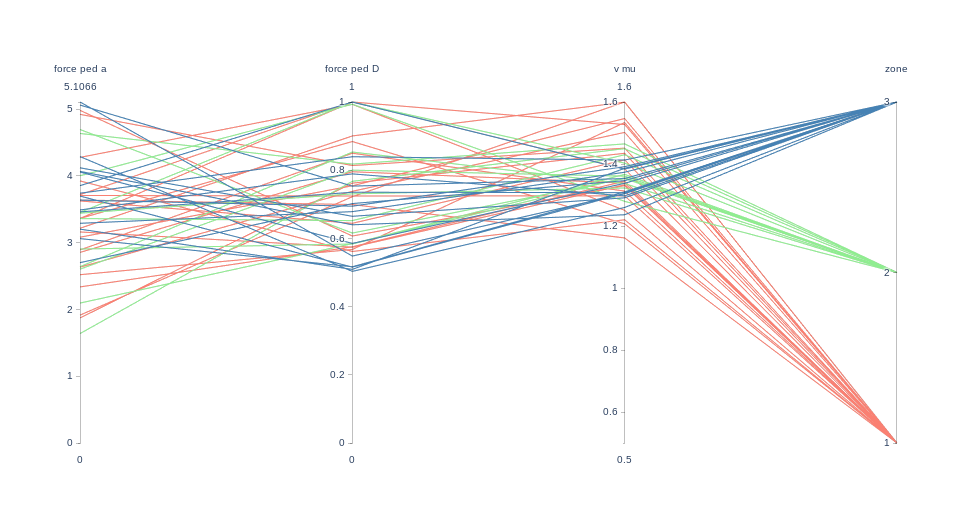

In [11]:
# Load saved image as parallel plots don't save within the notebook.
image = Image.open('../hm_true_pp.png')
display(image)

## Introducing velocity

We next investigate velocity in the *true* model run. The velocities in zones 1 and 2 are similar. In zone 3 (the overall environment) agents walked slightly slower, but we don't know if this difference is significant.

In [12]:
TRUE_REPORT_FP = 'results/true/report_results_true%s' % REPORT_FP

obs = [(analyse_density_model.density('%s%d.dat' % (TRUE_REPORT_FP, i)),
        analyse_density_model.velocity('%s%d.dat' % (TRUE_REPORT_FP, i)))
           for i in range(1, 4)]
df = pd.DataFrame(obs, columns=('Density', 'Velocity'), index=('1', '2', '3'))
df

,Density,Velocity
1,0.042294,1.309525
2,0.062323,1.310154
3,0.041872,1.169076


Next, we'll run history matching but this time we compare both the density and velocity of agents to assess the plausibility of model parameters. 